In [1]:
%matplotlib inline
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as sla
import scipy.linalg as la
from scipy.optimize import root, fmin

fparams = {'axes.labelsize': 18,
           'axes.titlesize': 18,
           'font.size': 18,
           'legend.fontsize': 16,
           'font.family': 'serif',
           'font.serif': 'Computer Modern Roman',
           'xtick.labelsize': 16,
           'ytick.labelsize': 16,
           'text.usetex': True,
           'figure.autolayout': True}
plt.rcParams.update(fparams)

class SimpleNamespace(object):
    """A simple container for parameters."""
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

## Model

We consider a DC squid with one weak link (phase difference $\phi$) and one conventional junction (phase difference $\varphi-\phi$, with $\varphi$ the flux through the squid in units of the superconducting flux quantum):

![caption](squid.png)

Josephson energy of the weak link:

$$
- E_A \sqrt{1-T \sin^2[(\varphi-\phi)/2]}
$$

with $T$ the transmission coefficient through the junction. Josephson energy of the tunnel junction:

$$
E_J [1-\cos(\phi)]
$$

Total Josephson energy in the ground state of the junction (no excited Andreev pairs):

$$
E_\textrm{tot}(\phi, \varphi) = E_J [1-\cos(\phi)] - E_A \sqrt{1-T \sin^2[(\varphi-\phi)/2]}
$$

Ignoring charging energy (for the moment), the ground state energy is obtained by minimizing $E_\textrm{tot}$ over $\phi$. Current through the weak link:

$$
I_A = \frac{2e}{\hbar}\,\frac{E_A T}{4}\,\frac{\sin (\varphi-\phi)}{\sqrt{1-T \sin^2[(\varphi-\phi)/2]}}
$$

Current through the tunnel junction:

$$
I_J = \frac{2e}{\hbar}\,E_J \sin \phi
$$

Note that the signs of $I_A$ and $I_J$ are both defined to be positive with respect to the counterclockwise [$\circlearrowleft$] direction in the SQUID. If an external transport current $I_\textrm{ext}$ is passed through the junction (via a branch not shown in the figure above), then Kirchoff's rule gives $I_\textrm{ext}=I_J  - I_A$. The critical current of the SQUID is indeed given by

$$
I_c(\varphi) = \frac{2e}{\hbar}\max_\phi \partial_\phi E_\textrm{tot}(\phi, \varphi) = \frac{2e}{\hbar}\max_\phi\,\bigg[ E_J \sin\phi - E_A \frac{\sin (\varphi-\phi)}{\sqrt{1-T \sin^2[(\varphi-\phi)/2]}}\bigg]
$$

### Model for the weak link in presence of charging energy

If there is a charging energy and if one takes into account the possibility to excite a pair of electrons into the Andreev bound state, the Hamiltonian of the circuit is

$$H = E_C\,\sigma_0\,\hat{N}^2 + V(\hat{\phi})$$

where the potential energy is (taken from [this paper from Saclay](http://arxiv.org/pdf/1406.6301.pdf), actually derived in [this paper](http://arxiv.org/pdf/cond-mat/0206342.pdf) and [this paper](http://arxiv.org/pdf/cond-mat/0404656.pdf) by Zazunov, Shumeiko et al.)

$$
V(\hat\phi)=E_J\,\sigma_0\,[1-\cos(\varphi-\hat\phi)] + E_A\sigma_3\,V_3(\hat\phi) + E_A\,\sigma_2\,V_2(\hat\phi)\\
V_3(\hat\phi)=\cos\frac{\sqrt{R}\hat\phi}{2}\,\cos\frac{\hat\phi}{2}+\sqrt{R}\,\sin\frac{\sqrt{R}\hat\phi}{2}\,\sin\frac{\hat\phi}{2}\\
V_2(\hat\phi)=\sqrt{R}\,\cos\frac{\sqrt{R}\hat\phi}{2}\,\sin\frac{\hat\phi}{2}-\sin\frac{\sqrt{R}\hat\phi}{2}\,\cos\frac{\hat\phi}{2}
$$

Here $\sigma_0, \sigma_2, \sigma_3$ are Pauli matrices which distinguish the ground state from the state with an excited pair in the junction. $R=1-T$ is the reflection coefficient of the junction.

For very small charging energy, one may find the following expression for the plasma frequency at zero flux by expanding $V(\hat{\phi})$ around $\phi = 0$ and diagonalizing the $\sigma$ part. The result is

$$\hbar\omega_p = \sqrt{2 E_C\,(E_J + E_A T/4)}$$

This equation may be used to estimate the charging energy from the experimentally observed plasma frequency.

## Parameters for 30 nm device

Let me estimate the parameters of the model for the device with the 30 nm short junction.

From slide 35 of Attila's talk, we have $E_A\approx 140\,\mu$eV and $T=0.54$.

From David's table, I take the critical current of the tunnel junction $\max I_J=42.5 nA$. Via the relation $I = 2e E_J/\hbar$, this gives $E_J = 87\;\mu$eV.

Also from David's table, the plasma frequency for this device is estimated to be $\omega_p = 16.5$ GHz. This plasma frequency was measured at pinch-off, so it does not depend on $E_A$, $\omega_p \approx \sqrt{2E_C E_J}$. From this relation one may extract $E_c$. 

Converting everything to GHZ, I find:

$E_J / h \approx (1/h) \times 87\;µ$eV $\approx 21$ GHz.

$E_A / h \approx (1/h) \times 140\;µ$eV $\approx 33.8$ GHz.

$E_c \approx \omega_p^2/(2E_J) \approx 6.48$ GHz. 

In [2]:
p = SimpleNamespace(Ej = 21, Ec=6.48, Ea=33.8, T=0.54)

## Finding phase drop across the weak link

Ignoring charging energy for a moment, one may ask what is the phase $\phi$ which determines the phase drop across the weak link, as a function of the applied flux.

To answer this question, we seek to minimize the energy with respect to the phase at fixed flux. To find $\phi_0$ we must solve the following transcendental equation

\begin{equation}
E_J\sin(\phi_0)-\frac{E_A \,T\,\sin(\varphi-\phi_0)}{4\,\sqrt{1-T \sin^2[(\varphi-\phi_0)/2]}}=0 
\end{equation}

Clearly, when $E_J\gg E_A T/4$ the solution is given with good approximation by $\phi \approx 0$. Expanding the transcendental equation to first order in $\phi_0$, one finds the following approximate solution:

\begin{equation}
\phi_0\approx \frac{E_A T}{E_J}\,\frac{\sin\varphi}{\sqrt{1-T\sin^2\varphi/2}} + O[(E_AT/E_J)^2]\,.
\end{equation}

Alternatively, the solution can also be found numerically. I find that the two methods agree quite well, particularly for not too large transmission $T$.

In [3]:
def jos_energy(x, p):
    return p.Ej * (1 - np.cos(x)) - p.Ea * np.sqrt(1 - p.T * np.sin(0.5 * (p.flux - x))**2)

def andreev_energy(x, p):
    return - p.Ea * np.sqrt(1 - p.T * np.sin(0.5 * (p.flux - x))**2)

def phase_derivative_jos_energy(x, p):
    return p.Ej * np.sin(x) - p.Ea * p.T * np.sin(p.flux - x) / (4 * np.sqrt(1 - p.T * np.sin(0.5 * (p.flux - x))**2))

def andreev_current(x, p):
    return p.Ea * p.T * np.sin(p.flux - x) / (4 * np.sqrt(1 - p.T * np.sin(0.5 * (p.flux - x))**2))

In [4]:
fluxes = np.linspace(0, 2*np.pi, 500)
phi0s = []
for flux in fluxes:
    p.flux = flux
    sol = root(phase_derivative_jos_energy, [0.], p)
    phi0s.append(sol.x[0])  

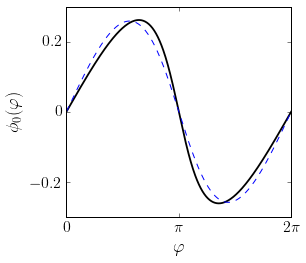

In [6]:
fig, ax = plt.subplots(figsize=(4.6,4))
ax.plot(fluxes, phi0s, 'k', lw = 1.8)
ax.plot(fluxes, -andreev_current(fluxes, p)/p.Ej, 'b--')
ax.set_xlim(0, 2*np.pi)
ax.set_xticks([0, np.pi, 2*np.pi])
ax.set_xticklabels([r'$0$', r'$\pi$', r'$2\pi$'])
ax.set_ylim(-0.3, 0.3)
ax.set_yticks([-0.2, 0, 0.2])
ax.set_yticklabels([r'$-0.2$', r'$0$', r'$0.2$'])
ax.set_xlabel(r'$\varphi$')
ax.set_ylabel(r'$\phi_0(\varphi)$')
fig.show()

Here is the solution for the phase $\phi_0$ as a function of $\phi$. The black one is the numerically determined one, the blue one is the analitical approximation. The correction is quite small and has a sine-like shape.

In the the next plot you can see the resulting difference in the dispersion of the Andreev energy, between $E_A(\varphi)$ and $E_A[\phi_0(\varphi)]$.

In [7]:
new_dispersion = []
for flux in fluxes:
    p.flux = flux
    sol = root(phase_derivative_jos_energy, [0.], p)
    new_dispersion.append(andreev_energy(sol.x[0], p))

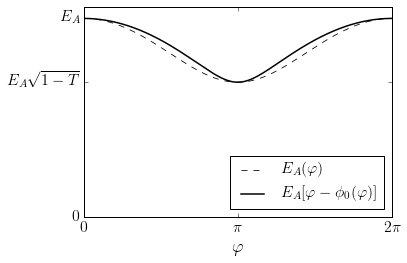

In [8]:
fig, ax = plt.subplots()
ax.plot(fluxes, -np.array(andreev_energy(fluxes, p)), 'k--', lw = 0.8, label = r'$E_A(\varphi)$')
ax.plot(fluxes, -np.array(new_dispersion), 'k', lw=1.5, label = r'$E_A[\varphi-\phi_0(\varphi)]$')
ax.legend(loc=4)
ax.set_xlim(0, 2*np.pi)
ax.set_xlim(0, 2*np.pi)
ax.set_xticks([0, np.pi, 2*np.pi])
ax.set_xticklabels([r'$0$', r'$\pi$', r'$2\pi$'])
ax.set_xlabel(r'$\varphi$')
ax.set_ylim(0, p.Ea + 2)
ax.set_yticks([0, p.Ea, p.Ea * np.sqrt(1-p.T)])
ax.set_yticklabels([r'$0$', r'$E_A$', r'$E_A \sqrt{1-T}$'])

The dashed line is the curve you would have if the phase drop at the weak link was exactly equal to the applied flux. Taking into account for the deviation from this condition results into the black curve. The effect is visible, and would be more marked at stronger transmission.

Perhaps it goes into the opposite direction as what we expected, since 'by eye' the data may look to be 'compressed' around $\varphi=0$. Maybe I have a sign error in $\phi_0$?

## Critical current of the squid

In [9]:
fluxes = np.linspace(0, 2*np.pi, 200)
Ics = []
for flux in fluxes:
    p.flux = flux
    def f(x):
        return - phase_derivative_jos_energy(x, p)
    sol = fmin(f, [np.pi / 2], disp=0)
    Ics.append(-f(sol[0]))

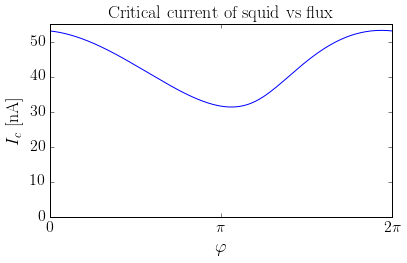

In [10]:
fig, ax = plt.subplots()
# factor of 2.013 converts GHz to nA:
# I use the relation Ic = (2e / hbar) Ej = (4π e) * (Ej / h)
# Then I get 4π * electron charge * 1GHz = 2.013 nA
ax.plot(fluxes, 2.013 * np.array(Ics)) 
ax.set_xlim(0, 2*np.pi)
ax.set_xlim(0, 2*np.pi)
ax.set_xticks([0, np.pi, 2*np.pi])
ax.set_xticklabels([r'$0$', r'$\pi$', r'$2\pi$'])
ax.set_xlabel(r'$\varphi$')
ax.set_ylim(0, 55)
ax.set_ylabel('$I_c$ [nA]')
ax.set_title('Critical current of squid vs flux')

This does not seem to be far off with from what is observed. The maximum critical current of the squid roughly coincides approximately with $(2e/\hbar) \times (E_J + E_A T/4)$, i.e. the sum of the critical currents of the two junctions. The skewness is clearly visible.

## Functions which diagonalize the full Hamiltonian, including charging energy

The Hamiltonian is represented in the phase basis, discretizing the $[0, 2\pi)$ with a lattice spacing $2\pi/M$. The integer parameter $M$ is then chosen such that convergence of the eigenvalues is reached (i.e., $M$ is chosen to be at the threshold such that increasing $M$ further does not change the eigenvalues found numerically).

In [11]:
def potential(phi, p, s='0'):
    r = np.sqrt(1 - p.T) # use reflection amplitude in the formulas, for brevity
    if s == 'z':
        phi = p.flux - phi
        return np.cos(0.5 * r * phi) * np.cos(0.5 * phi) + r * np.sin(0.5 * r * phi) * np.sin(0.5 * phi)
    elif s  == 'y':
        phi = p.flux - phi
        return r * np.cos(0.5 * r * phi) * np.sin(0.5 * phi) - np.sin(0.5 * r * phi) * np.cos(0.5 * phi)
    elif s == '0':
        return (1 - np.cos(phi))
    else:
        raise ValueError('wrong value of s')
        
def n_me(M, dk):
    x = np.pi * dk / M
    return (-1)**dk  / (np.tan(x) * np.sin(x)) / 2

In [12]:
def create_hamiltonian(p, M, sparse=False):
    # offset diagonal term from charging energy
    h0 = p.Ec * (M**2 - 1) / 12 * np.eye(M) + 0j
    
    # cosine part of the potential
    ks = np.arange(-(M-1)/2, (M+1)/2, 1)
    h0 += p.Ej * np.diag(np.array([potential(2 * np.pi * k / M, p, '0') for k in ks])) + 0j
     
    #off diagonal parts of the charging energy
    for dk in range(1, M):
        h0 += p.Ec * n_me(M, dk) * (np.eye(M, k=dk) + np.eye(M, k=-dk)) + 0j
    
    # z, y parts of the potential
    hz = p.Ea * np.diag(np.array([potential(2 * np.pi * k / M, p, 'z') for k in ks])) + 0j
    hy = p.Ea * np.diag(np.array([potential(2 * np.pi * k / M, p, 'y') for k in ks])) + 0j
    
    h = np.bmat([[h0 + hz, -1j * hy], [1j * hy, h0 - hz]])
    if sparse:
        return sp.coo_matrix(h)
    else:
        return np.array(h)
    
def find_optimal_M(p, max_tol = 9e-8, verbose=False):
    M = 3
    tol = 100
    H = create_hamiltonian(p, M, sparse=False)
    ens = np.linalg.eigvalsh(H)
    de = ens[1]-ens[0]
    while tol > max_tol:
        M += 4
        H = create_hamiltonian(p, M, sparse=False)
        ens = np.linalg.eigvalsh(H)
        de_new = ens[1]-ens[0]
        tol = np.abs(de_new - de)
        if verbose:
            print M, de, de_new, tol
        de = de_new
    return M

# This function is work in progress - ignore for the moment
def eigenvectors(p):
    if hasattr(p, 'M')==False:
        p.M = find_optimal_M(p)
    H = create_hamiltonian(p, p.M, sparse=False)
    evals, evec = np.linalg.eigh(H)
    #ks = np.arange(-(M-1)/2, (M+1)/2, 1)
    #j0 = np.diag(np.array([np.exp(1j * 2 * np.pi * k / M) for k in ks])) + 0j
    #j_op = np.bmat([[j0, np.zeros((M, M))], [np.zeros((M, M)), j0]])
    #J = np.abs(np.conj(evec).T.dot(j_op.dot(evec)))
    #plt.imshow(np.flipud(J**2), interpolation='none', extent=(0,M,0,M))
    #plt.colorbar()
    return evec

## Current operator (for the matrix elements of the transitions)

The current operator is given by

$$
I(\hat{\phi}) = \frac{\partial V}{\partial \hat{\phi}} = E_J\,\sin\hat{\phi}\,\sigma_0 - \frac{E_A\,T}{2}\,\sin \frac{\varphi-\hat{\phi}}{2}\,\left[\sigma_3\,\cos \frac{\sqrt{R}(\varphi-\hat{\phi})}{2} + \sigma_2\,\cos \frac{\sqrt{R}(\varphi-\hat{\phi})}{2}\right]
$$

The intensity of the microwave-induced transition line between eigenstates $n$ and $m$ is $\propto |\langle m| I(\hat{\phi}) |n\rangle|^2$. The next functions compute this operator.

In [14]:
def potential_derivative(phi, p, s='0'):
    r = np.sqrt(1 - p.T) # use reflection amplitude in the formulas, for brevity
    if s == 'z':
        phi = p.flux - phi
        return - 0.5 * p.T * np.sin(0.5 * phi) * np.cos(r * 0.5 * phi)
    elif s  == 'y':
        phi = p.flux - phi
        return + 0.5 * p.T * np.sin(0.5 * phi) * np.sin(r * 0.5 * phi)
    elif s == '0':
        return np.sin(phi)
    else:
        raise ValueError('wrong value of s')


def current_operator(p, sparse=False):
    #if hasattr(p, 'M')==False:
    M = p.M if hasattr(p, 'M') else find_optimal_M(p)
    
    ks = np.arange(-(M-1)/2, (M+1)/2, 1)
    I0 = p.Ej * np.diag(np.array([potential_derivative(2 * np.pi * k / M, p, '0') for k in ks])) + 0j
    Iz = p.Ea * np.diag(np.array([potential_derivative(2 * np.pi * k / M, p, 'z') for k in ks])) + 0j
    Iy = p.Ea * np.diag(np.array([potential_derivative(2 * np.pi * k / M, p, 'y') for k in ks])) + 0j
    
    I = np.bmat([[I0 + Iz, -1j * Iy], [1j * Iy, I0 - Iz]])
    if sparse:
        return sp.coo_matrix(I)
    else:
        return np.array(I)

## Spectrum and transition frequencies of the 30nm device

In [15]:
p.M=find_optimal_M(p, max_tol = 1e-7, verbose=False)

In [17]:
fluxes = np.linspace(0, 2*np.pi, 500)
spectra = []
for flux in fluxes:
    p.flux = flux
    H = create_hamiltonian(p, p.M, sparse=False)
    ens = np.sort(np.linalg.eigvalsh(H))
    spectra.append(ens[:50])
freqs = np.vstack([(s - s[0])[1:] for s in spectra])

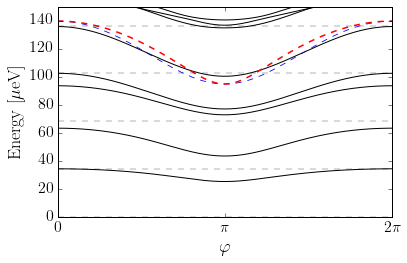

In [19]:
fig, ax = plt.subplots()
# I want to convert frequency (GHz) to energy (µeV).
# 2eV = hf ==> h * 1 GHz = (2 * 2.067) µeV
for (n, f) in enumerate(freqs.T):
    ax.plot(fluxes, 2.067*f, c='k')
# I also plot the 'bare' Andreev dispersion
# There is an additional factor of 2 because the lines is expected at ~ 2 * Ea
ax.plot(fluxes, -2*2.067*np.array(andreev_energy(fluxes, p)), 'b--', lw = 0.8)
ax.plot(fluxes, -2*2.067*np.array(andreev_energy(fluxes - phi0s, p)), 'r--', lw=1.5)
ax.set_xlim(0, 2*np.pi)
ax.set_xticks([0, np.pi, 2*np.pi])
ax.set_xticklabels([r'$0$', r'$\pi$', r'$2\pi$'])
ax.set_xlabel(r'$\varphi$')
ax.set_ylim(0, 150)
ax.set_ylabel('Energy [$\mu$eV]')
for n in xrange(10):
    plt.axhline(2.067 * n * np.sqrt(2*p.Ec*p.Ej), c='k', ls='--', lw = 0.3)
    #plt.axhline(2 * 2.067* p.Ea + 2.067 * n * np.sqrt(2*p.Ec*p.Ej), c='r', lw=0.2)
fig.show()

Above you see the energy differences $E_n-E_0$ between the excited states and the ground state of the system. That's much better than before - fewer lines in between the main plasma frequency and the Andreev one.

In red and blue I plottes the energy dispersion $2E_A(\varphi)$ and $2E_A[\phi_0(\varphi)]$, the same I plotted in a couple plots above. You can see that they coincide fairly well with the fifth line.

Still to investigate the visibility of those other lines between 40 $\mu$eV and 100 $\mu$eV. I checked that the wavefunctions of these states has only a small component on the excited Andreev states, so these are mainly plasmons (plots of the wave functions are below). On the other hand, I checked that the state participating in the transition starting at about 140 $\mu$eV corresponds to a state with a large component on the excited Andreev states. In both cases, however, due to $E_J$ and $E_A$ being comparable, there is quite some hybridization.

The faint dashed lines give, as a reference, the frequencies $n\,\omega_p$ which you would have for a harmonic spectrum of plasmons. Note that by coincidence we have $E_a \approx 2\omega_p$. That's why I think the fourth plasma excitations is pushed down from $\approx$ 140 $\mu$eV to $\approx$ 100 $\mu$eV.

The plasma frequency now disperses with flux but its value is off from the observed one. That's because $E_A \gtrsim E_J$, so that the plasma frequency is much higher than the one at pinch off. However, am I perhaps underestimating $E_J$?

### Magnitude of current operator matrix elements

Below I plot the absolute value of the current matrix element between the ground state and the $n$-th excited state, at $\varphi=\pi$. As you can see, the dominating lines are those corresponding to the $0 \to 1$ and $0 \to 5$ transitions.

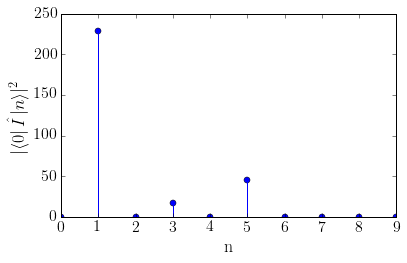

In [20]:
p.flux = np.pi
wavefunctions = eigenvectors(p).T
iop = current_operator(p)
matrix_elements = np.array([np.abs(np.conj(wavefunctions[0]).T.dot(iop).dot(wf))**2 for wf in wavefunctions])
fig, ax = plt.subplots()
ax.stem(matrix_elements[:10])
ax.set_xlabel('n')
ax.set_ylabel(r'$|\langle0|\,\hat{I}\,|n\rangle|^2$')
plt.show()

### Plots of the low-lying wave functions

Below you can find the plots of the wave functions at $\varphi=\pi$, if you are curious to care - they are not that essential. On the right of the vertical line the part of the wave function projected on the ground state of the weak link, on the left of the vertical line the part of the wave function projected on the excited state of the weak link.

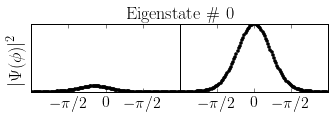

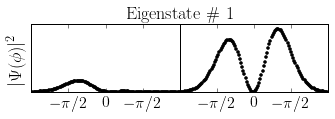

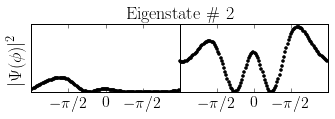

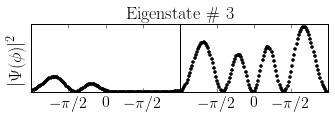

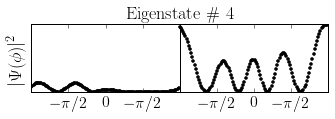

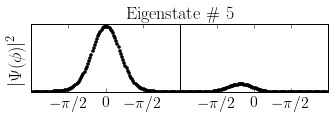

In [23]:
wavefunctions = eigenvectors(p).T
for (n, wf) in enumerate(wavefunctions[:6]):
    L = len(wf)
    fig, ax = plt.subplots(figsize=(5,2))
    ax.plot(np.abs(wf)**2, 'k.')
    ax.set_xlim(0, L)
    plt.axvline(L/2, c='k')
    ax.set_ylabel(r'$|\Psi(\phi)|^2$')
    ax.set_xticks([L/8, L/4, 3*L/8, 5*L/8, 3*L/4, 7*L/8])
    ax.set_xticklabels([r'$-\pi/2$', r'$0$', r'$-\pi/2$', r'$-\pi/2$', r'$0$', r'$-\pi/2$'])
    ax.set_yticks([])
    ax.set_title('Eigenstate \# %s' % n)
    fig.show()

## A check: Figure from Saclay's paper

In [24]:
p_saclay = SimpleNamespace(Ej = 900, Ea = 43, Ec=0.270, T=0.985, flux=0)

In [25]:
M=find_optimal_M(p_saclay, max_tol = 1e-10)
fluxes = np.linspace(0, 2*np.pi, 500)
spectra = []
for flux in fluxes:
    p_saclay.flux = flux
    H = create_hamiltonian(p_saclay, M, sparse=False)
    ens = np.sort(np.linalg.eigvalsh(H))
    spectra.append(ens[:30])
freqs = np.vstack([(s - s[0])[1:] for s in spectra])

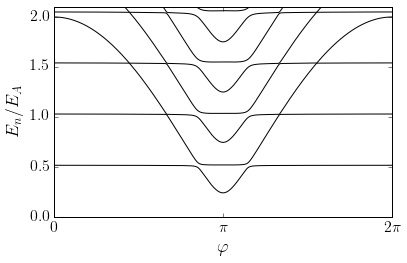

In [26]:
fig, ax = plt.subplots()
for f in freqs.T:
    ax.plot(fluxes, f/p_saclay.Ea, c='k');
ax.set_ylim(0, 2.1)
ax.set_xlim(0, 2*np.pi)
ax.set_xticks([0, np.pi, 2*np.pi])
ax.set_xticklabels([r'$0$', r'$\pi$', r'$2\pi$'])
ax.set_xlabel(r'$\varphi$')
ax.set_ylabel(r'$E_n/E_A$')
fig.show()

This figure should be compared with Fig. 4b of [this paper from Saclay](http://arxiv.org/pdf/1406.6301.pdf). I made it to check that the numerics do give sensible result as well to compare the two devices, which somehow operate in different regimes ($E_A\approx \omega_p$ here, vs $E_A\gg \omega_p$ above).

Below the wave functions: you can see that, compared to the ones for the 30 nm device, there is no hybridization: they are either all projected on the ground state of the weak link, or all projected on the excited state.

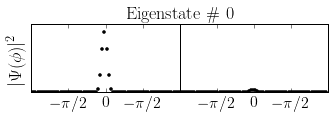

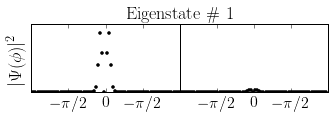

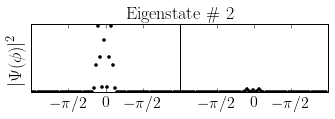

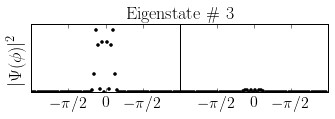

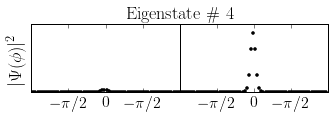

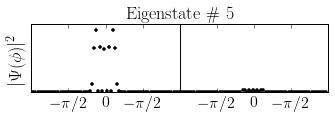

In [27]:
wavefunctions_saclay = np.abs(eigenvectors(p_saclay).T)**2
for (n, wf) in enumerate(wavefunctions_saclay[:6]):
    L = len(wf)
    fig, ax = plt.subplots(figsize=(5,2))
    ax.plot(wf, 'k.')
    ax.set_xlim(0, L)
    plt.axvline(L/2, c='k')
    ax.set_ylabel(r'$|\Psi(\phi)|^2$')
    ax.set_xticks([L/8, L/4, 3*L/8, 5*L/8, 3*L/4, 7*L/8])
    ax.set_xticklabels([r'$-\pi/2$', r'$0$', r'$-\pi/2$', r'$-\pi/2$', r'$0$', r'$-\pi/2$'])
    ax.set_yticks([])
    ax.set_title('Eigenstate \# %s' % n)
    fig.show()

## Another check: reproducing Fig. 4 of our paper with Gijs

I take comparable parameters, and check if these new numerics would give a similar frequency spectrum.

In [28]:
p_gijs_paper = SimpleNamespace(Ej = 80.84, Ea = 233, Ec=4*0.279, T = 0.885, flux = 0)

In [29]:
M=find_optimal_M(p_gijs_paper, max_tol = 1e-10)
fluxes = np.linspace(np.pi- 0.1, np.pi+0.1, 200)

In [30]:
spectra = []
for flux in fluxes:
    p_gijs_paper.flux = flux
    H = create_hamiltonian(p_gijs_paper, M, sparse=False)
    ens = np.sort(np.linalg.eigvalsh(H))
    spectra.append(ens[:30])

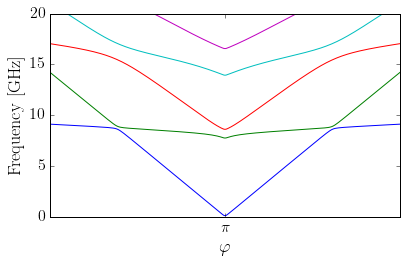

In [31]:
freqs = [(s - s[0])[1:] for s in spectra]
fig, ax = plt.subplots()
ax.plot(fluxes, np.array(freqs));
ax.set_ylim(0, 20)
ax.set_xlim(np.pi - 0.1, np.pi + 0.1)
ax.set_xticks([np.pi])
ax.set_xticklabels([r'$\pi$'])
ax.set_xlabel(r'$\varphi$')
ax.set_ylabel('Frequency [GHz]')
fig.show()

It may have been interesting to see if a similar spectrum would have been observed at low frequencies also in the new devices. The region around zero frequency and phase $\approx \pi$ seems quite crowded in the data, although the data point resolution is very low.